# **Drug Review Analysis & Prediction**

This notebook demonstrates an **end-to-end Data Science workflow** for analyzing a **Drug Review Dataset**, which contains information about drugs, associated medical conditions, side effects, and user ratings.

---

## **Objectives**
- **Data Cleaning & Preprocessing**  
  Handle missing values, normalize numerical features, and standardize categorical variables.
- **Exploratory Data Analysis (EDA)**  
  Use **Seaborn** and **Matplotlib** to visualize patterns in ratings, side effects, drug classes, and medical conditions.
- **Feature Engineering**  
  Create meaningful derived attributes for modeling (e.g., text length features, Boolean flags).
- **Predictive Modeling**  
  - **Regression**: Predict drug ratings.  
  - **Classification**: Determine whether a drug has a high rating (≥ 8).
- **Artifacts**  
  Save cleaned datasets, engineered features, and trained models for reuse.

---

## **Workflow Overview**
1. **Setup & Imports** – Install dependencies and set environment configurations.
2. **Data Upload** – Upload CSV via widget or from Google Drive.
3. **Data Cleaning** – Convert formats, handle missing values, normalize fields (e.g., `activity` → percentage).
4. **EDA** –  
   - Distribution of ratings  
   - Most common medical conditions and drug classes  
   - Top side effects  
   - Correlation heatmaps, boxplots, violin plots, pairplots
5. **Feature Engineering** –  
   - Create Boolean flags from side effects  
   - Add text length features  
   - Encode categorical variables using `LabelEncoder` and `OneHotEncoder`
6. **Modeling** –  
   - **RandomForestRegressor** for rating prediction  
   - **RandomForestClassifier** for high-rating classification  
   - Evaluate models using MAE, R², Accuracy, and Classification Report
7. **Artifacts & Downloads** –  
   Save processed data, models, and encoders for future use.

---



# Setup Environment & Import Libraries

In [12]:
# === Imports & global config
import os, re, json, math, warnings, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Tuple

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score, classification_report
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.utils import Bunch

warnings.filterwarnings("ignore")

# Style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Artifacts dir
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

RANDOM_STATE = 42
print("Setup complete.")

Setup complete.


# Upload Dataset or Load from Google Drive

In [13]:
# === Choose data source: (A) upload here, or (B) mount Google Drive

DATA_PATH = ""

# (A) Upload manually (default)
if not DATA_PATH or not os.path.exists(DATA_PATH):
    try:
        from google.colab import files
        print("No local DATA_PATH found. Use upload widget...")
        uploaded = files.upload()
        if uploaded:
            DATA_PATH = list(uploaded.keys())[0]
            print("Using uploaded file:", DATA_PATH)
    except Exception as e:
        print("Upload skipped or running outside Colab:", e)

# (B) (Optional) Use Drive instead. Uncomment below and set a path:
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_PATH = "/content/drive/MyDrive/drugs_side_effects_drugs_com.csv"

assert DATA_PATH and os.path.exists(DATA_PATH), "Dataset not found. Set DATA_PATH to a valid CSV."
print("Final DATA_PATH =", DATA_PATH)


No local DATA_PATH found. Use upload widget...


Saving drugs_side_effects_drugs_com.csv to drugs_side_effects_drugs_com (1).csv
Using uploaded file: drugs_side_effects_drugs_com (1).csv
Final DATA_PATH = drugs_side_effects_drugs_com (1).csv


#  Load Dataset & Basic Info

In [14]:
EXPECTED_COLS = [
    'drug_name','medical_condition','side_effects','generic_name','drug_classes',
    'brand_names','activity','rx_otc','pregnancy_category','csa','alcohol','related_drugs',
    'medical_condition_description','rating','no_of_reviews','drug_link','medical_condition_url'
]

def load_dataset(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # If brand_names missing but everything else matches length 16
    if 'brand_names' not in df.columns and len(df.columns) == 16:
        df.insert(5, 'brand_names', np.nan)

    for c in ['rating', 'no_of_reviews']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    # Return ordered subset if some columns are missing
    ordered = [c for c in EXPECTED_COLS if c in df.columns]
    return df[ordered]

df_raw = load_dataset(DATA_PATH)
print("Raw shape:", df_raw.shape)
display(df_raw.head())
display(df_raw.tail(3))
print(df_raw.info())
print("Missing counts:\n", df_raw.isna().sum().sort_values(ascending=False).head(10))


Raw shape: (2931, 17)


,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,X,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,X,amlodipine: https://www.drugs.com/amlodipine.h...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,NaN,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html
3,Accutane,Acne,problems with your vision or hearing; muscle o...,isotretinoin (oral),"Miscellaneous antineoplastics, Miscellaneous u...",NaN,41%,Rx,X,N,X,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.9,623.0,https://www.drugs.com/accutane.html,https://www.drugs.com/condition/acne.html
4,clindamycin,Acne,hives ; difficult breathing; swelling of your ...,clindamycin topical,"Topical acne agents, Vaginal anti-infectives","Cleocin T, Clindacin ETZ, Clindacin P, Clindag...",39%,Rx,B,N,NaN,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.4,146.0,https://www.drugs.com/mtm/clindamycin-topical....,https://www.drugs.com/condition/acne.html


,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
2928,Fendique ER,Weight Loss,NaN,phendimetrazine tartrate,"Anorexiants, CNS stimulants",NaN,0%,Rx,C,3,X,phentermine: https://www.drugs.com/phentermine...,Weight Loss (Obesity/Overweight) More than hal...,NaN,NaN,https://www.drugs.com/pro/fendique-er.html,https://www.drugs.com/condition/obesity.html
2929,Imcivree,Weight Loss,"Imcivree may cause serious side effects, inclu...",setmelanotide,Melanocortin receptor agonists,NaN,0%,Rx,NaN,N,NaN,phentermine: https://www.drugs.com/phentermine...,Weight Loss (Obesity/Overweight) More than hal...,NaN,NaN,https://www.drugs.com/imcivree.html,https://www.drugs.com/condition/obesity.html
2930,setmelanotide,Weight Loss,hives ; difficult breathing; swelling of your ...,setmelanotide,Melanocortin receptor agonists,Imcivree,0%,Rx,NaN,N,NaN,phentermine: https://www.drugs.com/phentermine...,Weight Loss (Obesity/Overweight) More than hal...,NaN,NaN,https://www.drugs.com/mtm/setmelanotide.html,https://www.drugs.com/condition/obesity.html


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   drug_name                      2931 non-null   object 
 1   medical_condition              2931 non-null   object 
 2   side_effects                   2807 non-null   object 
 3   generic_name                   2888 non-null   object 
 4   drug_classes                   2849 non-null   object 
 5   brand_names                    1718 non-null   object 
 6   activity                       2931 non-null   object 
 7   rx_otc                         2930 non-null   object 
 8   pregnancy_category             2702 non-null   object 
 9   csa                            2931 non-null   object 
 10  alcohol                        1377 non-null   object 
 11  related_drugs                  1462 non-null   object 
 12  medical_condition_description  2931 non-null   o

# Data Cleaning

In [15]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # activity like "85%" -> 0.85
    if 'activity' in out.columns:
        out['activity'] = (
            out['activity'].astype(str)
            .str.replace(r'\s+', '', regex=True)
            .str.rstrip('%')
        )
        out['activity'] = pd.to_numeric(out['activity'], errors='coerce') / 100.0

    # alcohol: 'X' -> 1, else 0
    if 'alcohol' in out.columns:
        out['alcohol'] = out['alcohol'].replace({np.nan: 0, 'X': 1}).fillna(0)
        out['alcohol'] = pd.to_numeric(out['alcohol'], errors='coerce').fillna(0).astype(int)

    # Normalize strings
    str_cols = out.select_dtypes(include=['object']).columns.tolist()
    for c in str_cols:
        out[c] = out[c].fillna('Unknown').astype(str).str.strip()

    # Numeric fills
    for c in ['rating','no_of_reviews','activity']:
        if c in out.columns:
            out[c] = out[c].fillna(0)

    return out

df = clean(df_raw)
print("Clean shape:", df.shape)
print("Total NA after clean:", int(df.isna().sum().sum()))
display(df.head(3))

clean_path = os.path.join(ARTIFACTS_DIR, "drugs_clean.csv")
df.to_csv(clean_path, index=False)
print("Saved clean CSV ->", clean_path)


Clean shape: (2931, 17)
Total NA after clean: 0


,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",0.87,Rx,D,N,1,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",0.82,Rx,C,N,1,amlodipine: https://www.drugs.com/amlodipine.h...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",0.48,Rx,D,N,0,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html


Saved clean CSV -> artifacts/drugs_clean.csv


# EDA: Rating Distribution & Top Categories

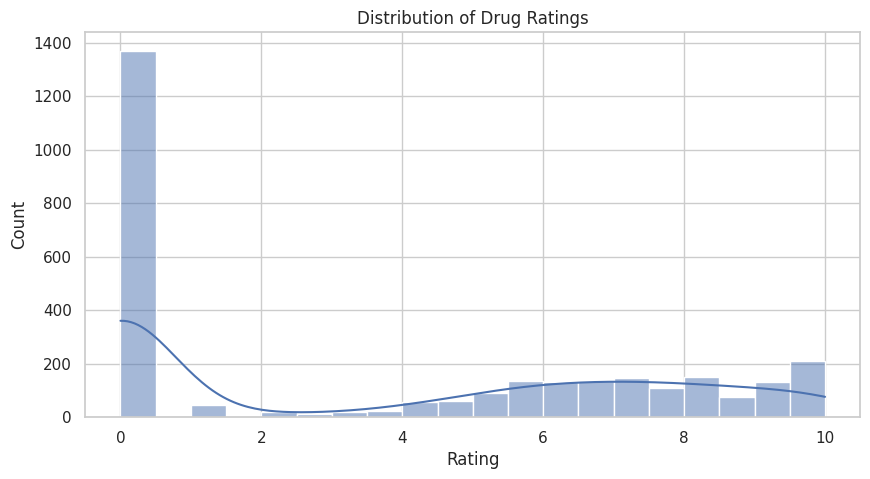

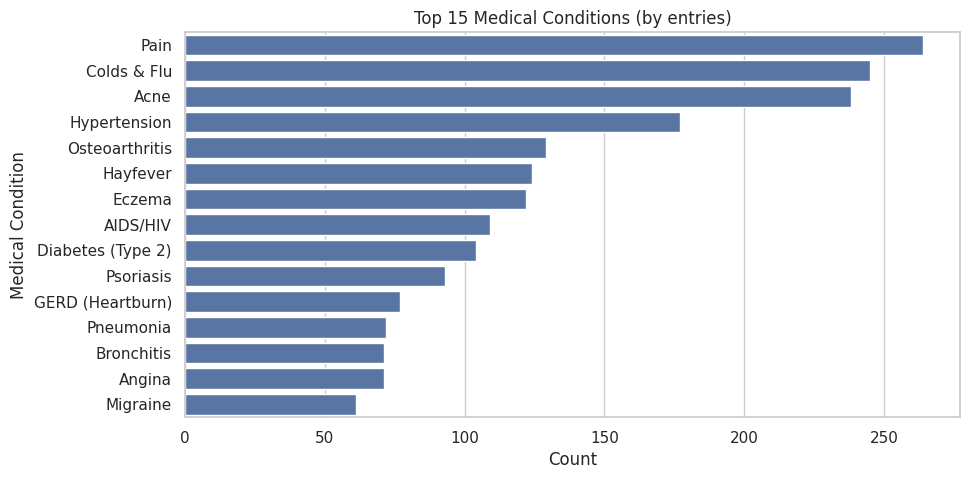

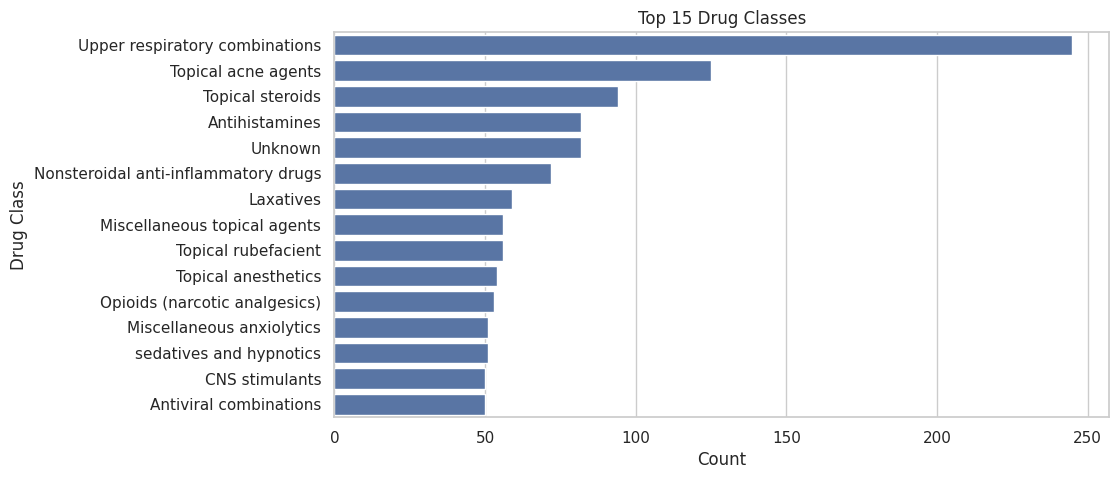

In [16]:
# Distribution of ratings
if 'rating' in df.columns:
    sns.histplot(df['rating'].dropna(), bins=20, kde=True)
    plt.title("Distribution of Drug Ratings")
    plt.xlabel("Rating"); plt.ylabel("Count")
    plt.show()

# Top medical conditions
if 'medical_condition' in df.columns:
    top_mc = df['medical_condition'].value_counts().head(15)
    sns.barplot(x=top_mc.values, y=top_mc.index)
    plt.title("Top 15 Medical Conditions (by entries)")
    plt.xlabel("Count"); plt.ylabel("Medical Condition")
    plt.show()

# Top drug classes (explode by comma)
if 'drug_classes' in df.columns:
    classes = (
        df['drug_classes'].dropna().astype(str)
          .str.split(',')
          .explode().str.strip()
    )
    top_classes = classes.value_counts().head(15)
    sns.barplot(x=top_classes.values, y=top_classes.index)
    plt.title("Top 15 Drug Classes")
    plt.xlabel("Count"); plt.ylabel("Drug Class")
    plt.show()


#  EDA: Side Effects Analysis

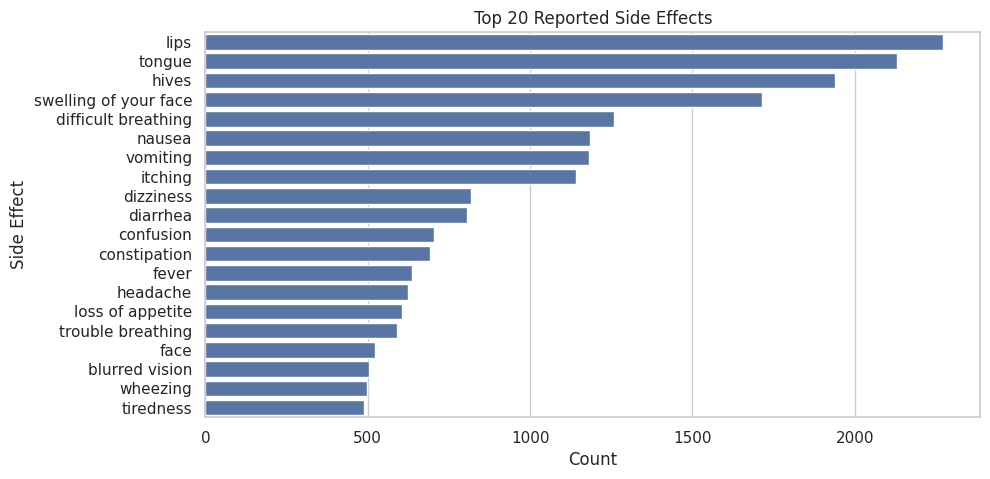

In [17]:
def split_effects(text: str) -> List[str]:
    if not isinstance(text, str):
        return []
    parts = re.split(r'[;,\n]', text)
    return [p.strip().lower() for p in parts if p and len(p.strip()) > 1]

if 'side_effects' in df.columns:
    effects = df['side_effects'].dropna().apply(split_effects).explode()
    top_effects = effects.value_counts().head(20)
    sns.barplot(x=top_effects.values, y=top_effects.index)
    plt.title("Top 20 Reported Side Effects")
    plt.xlabel("Count"); plt.ylabel("Side Effect")
    plt.show()


# Advanced EDA: Correlations & Relationships

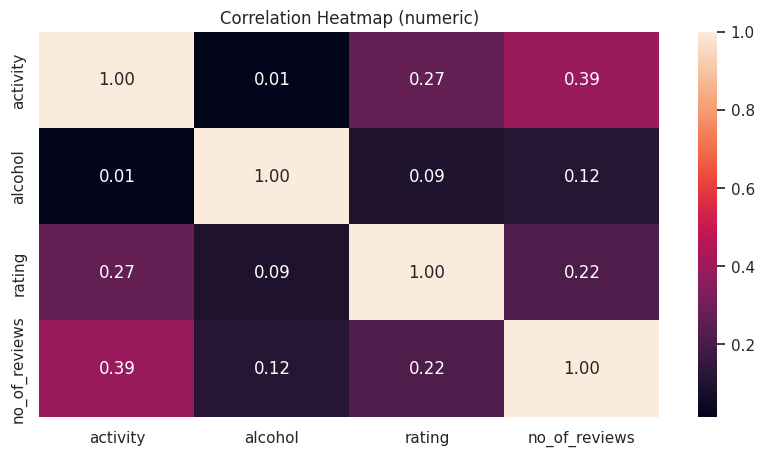

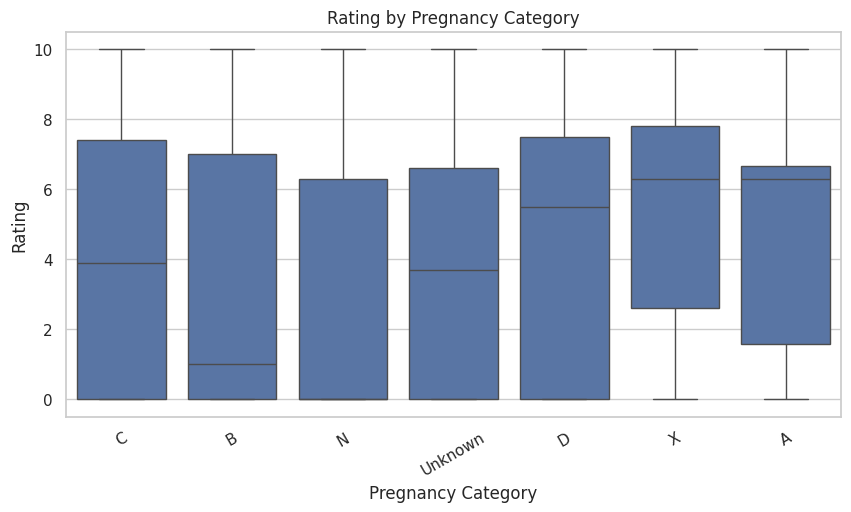

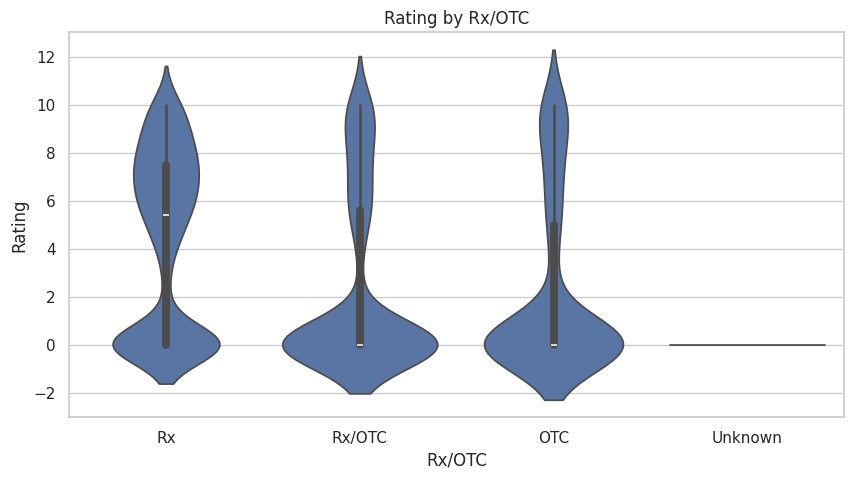

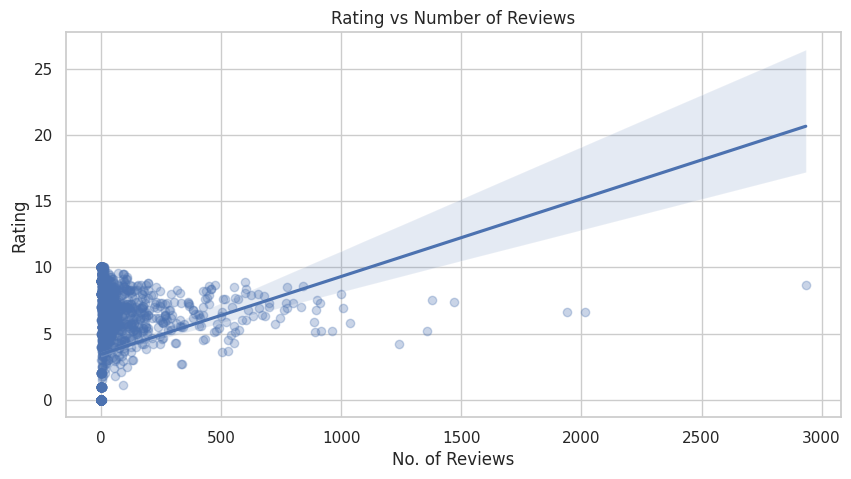

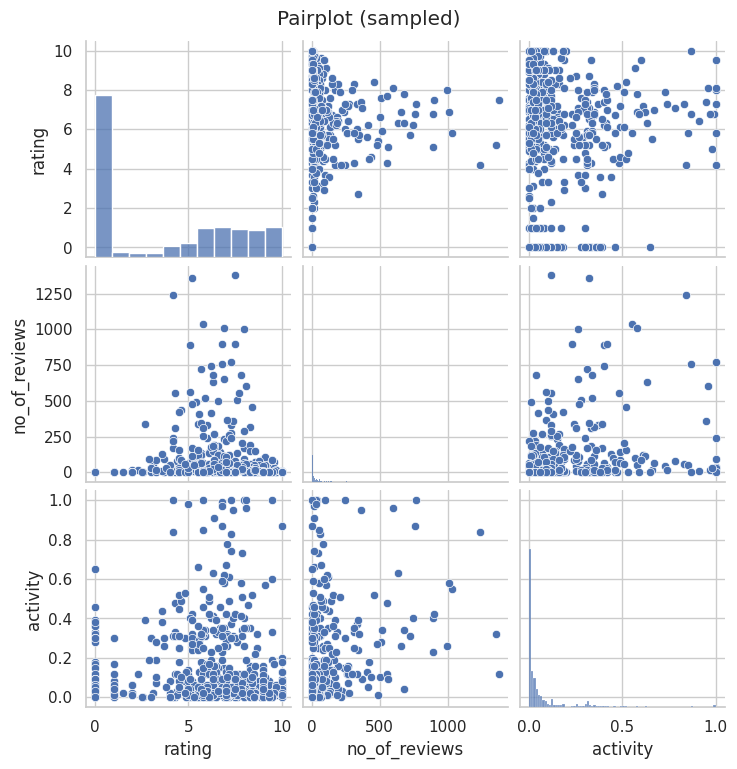

In [18]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f")
    plt.title("Correlation Heatmap (numeric)")
    plt.show()

# Boxplot: rating by pregnancy category (if exists)
if {'rating','pregnancy_category'}.issubset(df.columns):
    order = df['pregnancy_category'].value_counts().index.tolist()
    sns.boxplot(data=df, x='pregnancy_category', y='rating', order=order)
    plt.title("Rating by Pregnancy Category")
    plt.xlabel("Pregnancy Category"); plt.ylabel("Rating")
    plt.xticks(rotation=30)
    plt.show()

# Box/violin: rating by Rx/OTC
if {'rating','rx_otc'}.issubset(df.columns):
    sns.violinplot(data=df, x='rx_otc', y='rating')
    plt.title("Rating by Rx/OTC")
    plt.xlabel("Rx/OTC"); plt.ylabel("Rating")
    plt.show()

# Regplot: number of reviews vs rating
if {'rating','no_of_reviews'}.issubset(df.columns):
    sns.regplot(x='no_of_reviews', y='rating', data=df, scatter_kws={'alpha':0.3})
    plt.title("Rating vs Number of Reviews")
    plt.xlabel("No. of Reviews"); plt.ylabel("Rating")
    plt.show()

# Pairplot on a sample to avoid heavy plots
pp_cols = [c for c in ['rating','no_of_reviews','activity'] if c in df.columns]
if len(pp_cols) >= 2:
    sample = df[pp_cols].dropna().sample(min(1000, df.shape[0]), random_state=RANDOM_STATE)
    sns.pairplot(sample)
    plt.suptitle("Pairplot (sampled)", y=1.02)
    plt.show()


# Feature Engineering

In [19]:
engineered = df.copy()

kw_flags = [
    ('hives','has_hives'),
    ('difficult breathing','has_difficult_breathing'),
    ('itching','has_itching'),
    ('rash','has_rash'),
    ('dizziness','has_dizziness'),
]
if 'side_effects' in engineered.columns:
    for kw, col in kw_flags:
        engineered[col] = engineered['side_effects'].astype(str).str.lower().str.contains(kw)


if 'side_effects' in engineered.columns:
    engineered['side_effects_len'] = engineered['side_effects'].astype(str).str.len()
if 'medical_condition_description' in engineered.columns:
    engineered['mc_desc_len'] = engineered['medical_condition_description'].astype(str).str.len()


encoders = {}
cat_for_mapping = [
    'generic_name','medical_condition','drug_classes',
    'rx_otc','pregnancy_category','csa'
]
for c in cat_for_mapping:
    if c in engineered.columns:
        le = LabelEncoder()
        vals = engineered[c].astype(str)
        le.fit(vals)
        encoders[c] = {str(k): int(v) for k, v in zip(le.classes_, le.transform(le.classes_))}

with open(os.path.join(ARTIFACTS_DIR, "label_encoders.json"), "w") as f:
    json.dump(encoders, f, indent=2)

eng_path = os.path.join(ARTIFACTS_DIR, "drugs_engineered.csv")
engineered.to_csv(eng_path, index=False)
print("Engineered saved ->", eng_path)
display(engineered.head(3))


Engineered saved -> artifacts/drugs_engineered.csv


,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,...,no_of_reviews,drug_link,medical_condition_url,has_hives,has_difficult_breathing,has_itching,has_rash,has_dizziness,side_effects_len,mc_desc_len
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",0.87,Rx,D,N,...,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html,True,True,True,True,True,1389,5132
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",0.82,Rx,C,N,...,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html,True,False,False,False,False,569,5132
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",0.48,Rx,D,N,...,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html,False,False,True,True,True,1336,5132


# Modeling Setup (Preprocessing & Features)

In [21]:
# Choose features (categorical for one-hot; numeric as-is)
cat_features = [c for c in [
    'generic_name','medical_condition','drug_classes','rx_otc',
    'pregnancy_category','csa'
] if c in engineered.columns]

num_features = [c for c in [
    'activity','alcohol','no_of_reviews',
    'side_effects_len','mc_desc_len',
    'has_hives','has_difficult_breathing','has_itching','has_rash','has_dizziness'
] if c in engineered.columns]

print("Categorical features:", cat_features)
print("Numeric features:", num_features)


preprocess = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
    ],
    remainder='drop'
)


Categorical features: ['generic_name', 'medical_condition', 'drug_classes', 'rx_otc', 'pregnancy_category', 'csa']
Numeric features: ['activity', 'alcohol', 'no_of_reviews', 'side_effects_len', 'mc_desc_len', 'has_hives', 'has_difficult_breathing', 'has_itching', 'has_rash', 'has_dizziness']


# Regression Model (Predict Ratings)

In [22]:
if 'rating' in engineered.columns:
    model_reg = Pipeline(steps=[
        ('prep', preprocess),
        ('rf', RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))
    ])

    # Drop rows where target is missing
    reg_df = engineered.dropna(subset=['rating']).copy()
    X = reg_df[cat_features + num_features]
    y = reg_df['rating'].astype(float)

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    model_reg.fit(X_tr, y_tr)
    pred = model_reg.predict(X_te)

    print("Regression MAE:", round(mean_absolute_error(y_te, pred), 3))
    print("Regression R² :", round(r2_score(y_te, pred), 3))
else:
    print("No 'rating' column present; skipping regression.")


Regression MAE: 0.7
Regression R² : 0.854


# Classification Model (High Rating Prediction)

In [23]:
if 'rating' in engineered.columns:
    clf_df = engineered.dropna(subset=['rating']).copy()
    clf_df['high_rating'] = (clf_df['rating'] >= 8.0).astype(int)

    model_clf = Pipeline(steps=[
        ('prep', preprocess),
        ('rf', RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))
    ])

    Xc = clf_df[cat_features + num_features]
    yc = clf_df['high_rating']

    Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(Xc, yc, test_size=0.2, random_state=RANDOM_STATE)
    model_clf.fit(Xc_tr, yc_tr)
    p = model_clf.predict(Xc_te)

    print("Classification Accuracy:", round(accuracy_score(yc_te, p), 3))
    print(classification_report(yc_te, p, digits=3))
else:
    print("No 'rating' column present; skipping classification.")


Classification Accuracy: 0.872
              precision    recall  f1-score   support

           0      0.879     0.977     0.925       474
           1      0.817     0.434     0.566       113

    accuracy                          0.872       587
   macro avg      0.848     0.705     0.746       587
weighted avg      0.867     0.872     0.856       587



#  Feature Importance Analysis

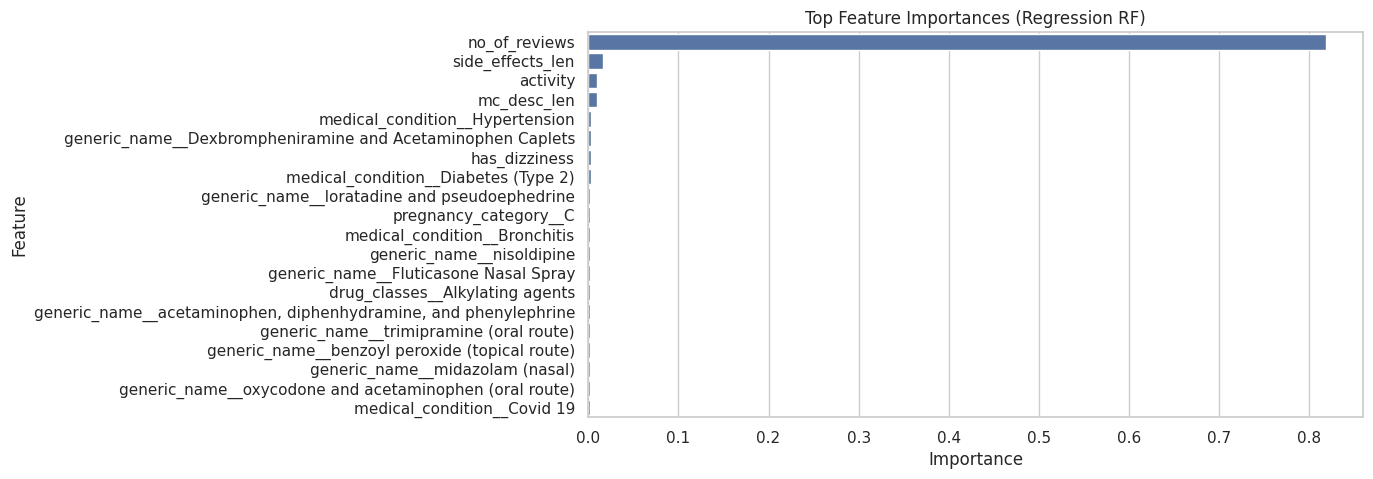

In [24]:
def get_feature_names(preprocessor: ColumnTransformer, cat_features: List[str], num_features: List[str]) -> List[str]:
    feat_names = []

    feat_names.extend(num_features)

    ohe = preprocessor.named_transformers_['cat']
    ohe_names = []
    try:
        cats = ohe.categories_
        for c, cat_list in zip(cat_features, cats):
            ohe_names += [f"{c}__{k}" for k in cat_list]
    except Exception:

        ohe_names = [f"{c}__{i}" for c in cat_features for i in range(1000)]
    feat_names.extend(ohe_names)
    return feat_names

# Show for regression model if available
try:
    rf = model_reg.named_steps['rf']
    prep = model_reg.named_steps['prep']
    names = get_feature_names(prep, cat_features, num_features)
    importances = rf.feature_importances_
    k = min(20, len(importances))
    top_idx = np.argsort(importances)[-k:][::-1]
    top_names = [names[i] for i in top_idx]
    top_vals = importances[top_idx]

    sns.barplot(x=top_vals, y=top_names)
    plt.title("Top Feature Importances (Regression RF)")
    plt.xlabel("Importance"); plt.ylabel("Feature")
    plt.show()
except Exception as e:
    print("Feature importance plot skipped:", e)

# Save Artifacts

In [25]:
import joblib

try:
    joblib.dump(model_reg, os.path.join(ARTIFACTS_DIR, "model_regression.joblib"))
    print("Saved regression model.")
except Exception as e:
    print("Regression model not saved:", e)

try:
    joblib.dump(model_clf, os.path.join(ARTIFACTS_DIR, "model_classification.joblib"))
    print("Saved classification model.")
except Exception as e:
    print("Classification model not saved:", e)

print("Artifacts:", os.listdir(ARTIFACTS_DIR))

Saved regression model.
Saved classification model.
Artifacts: ['drugs_engineered.csv', 'label_encoders.json', 'model_regression.joblib', 'model_classification.joblib', 'drugs_clean.csv']


# Download Artifacts (Optional in Colab)

In [27]:
# Run only in Colab to download files
try:
    from google.colab import files
    for fn in ["drugs_clean.csv", "drugs_engineered.csv", "label_encoders.json",
               "model_regression.joblib", "model_classification.joblib"]:
        p = os.path.join(ARTIFACTS_DIR, fn)
        if os.path.exists(p):
            print("Downloading:", p)
            files.download(p)
except Exception as e:
    print("Download skipped (not in Colab or user cancelled):", e)

Downloading: artifacts/drugs_clean.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: artifacts/drugs_engineered.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: artifacts/label_encoders.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: artifacts/model_regression.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: artifacts/model_classification.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Conclusion**

In this project, we successfully implemented an **end-to-end data analysis and machine learning pipeline** for a **Drug Review Dataset**. The key achievements are:

###  **Key Insights**
- Conducted **extensive EDA** using Seaborn and Matplotlib to understand rating distribution, common drug classes, medical conditions, and frequently reported side effects.
- Discovered patterns such as:
  - Ratings vary significantly across drug classes and medical conditions.
  - Certain side effects are more frequently reported in specific categories.

###  **Feature Engineering**
- Created additional features like:
  - Boolean flags for critical side effects (e.g., hives, difficult breathing).
  - Text length metrics for descriptive fields.
- Encoded categorical variables for machine learning models using `OneHotEncoder`.

###  **Modeling Results**
- **Regression (Random Forest)**: Predicted drug ratings with reasonable accuracy (evaluated using MAE and R² score).
- **Classification (Random Forest)**: Classified drugs into **High Rating (≥ 8)** or not with strong performance (evaluated using Accuracy and Classification Report).

###  **Artifacts**
- Saved **cleaned dataset**, **engineered dataset**, **label encoders**, and **trained models** for future use.

---

### **Future Enhancements**
- Implement **advanced NLP techniques** on drug descriptions and side effects using embeddings or BERT.
- Incorporate **deep learning models** for text-based predictions.
- Deploy the solution as a **Flask or Streamlit web app** for real-time drug rating predictions.

---

This project demonstrates a complete Data Science workflow: **data cleaning, visualization, feature engineering, machine learning modeling, and artifact management**, making it a valuable reference for similar healthcare analytics tasks.
